In [13]:
import pandas as pd
import numpy as np

df_40 = pd.read_csv("Data/all_opinions_1940.csv")
df_40['date_filed'] = df_40['date_filed'].apply(pd.to_datetime, errors='coerce')
df_40['author_lastname'] = df_40.author_name.apply(lambda x: x.split(" ")[-1]) #get last name of each justice
df_40['author_lastname'] = np.where((df_40['author_lastname'] == 'Roberts') & (df_40['year_filed']<2005), 'Roberts, O.', df_40['author_lastname'])
df_40 = df_40[df_40['per_curiam']==False] # per curiam opinions are opinions the court deemed to be so straightforward there is no named author
df_40 = df_40.drop(columns=['Unnamed: 0','federal_cite_one','absolute_url','cluster','per_curiam'])

print(df_40.shape)
print(df_40.dtypes)
df_40.head(3)

(14924, 11)
author_name                        object
category                           object
case_name                          object
date_filed                 datetime64[ns]
year_filed                          int64
scdb_id                            object
scdb_decision_direction           float64
scdb_votes_majority               float64
scdb_votes_minority               float64
text                               object
author_lastname                    object
dtype: object


,author_name,category,case_name,date_filed,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text,author_lastname
0,Justice Roberts,majority,McCutcheon v. Federal Election Comm'n,2014-04-02,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...,Roberts
1,Justice Thomas,concurring,McCutcheon v. Federal Election Comm'n,2014-04-02,2014,2013-033,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...,Thomas
2,Justice Breyer,dissenting,McCutcheon v. Federal Election Comm'n,2014-04-02,2014,2013-033,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U...",Breyer


In [14]:
from datetime import datetime
df_justice = pd.read_csv("./Data/JusticeData.csv")
df_justice = df_justice.drop(columns=['StateApptFrom'])
df_justice['JusticeLastName'] = df_justice.Name.apply(lambda x: x.split(",")[0]) #get last name of each justice
df_justice[['DateServiceTerminated','JudicialOathTaken']] = df_justice[['DateServiceTerminated','JudicialOathTaken']].apply(pd.to_datetime, errors='coerce')
df_justice['JusticeLastName'] = np.where((df_justice['JusticeLastName'] == 'Roberts') & (df_justice['DateServiceTerminated']<datetime.strptime('January 1, 2005', '%B %d, %Y')), 'Roberts, O.', df_justice['JusticeLastName'])
df_justice = df_justice[(df_justice['DateServiceTerminated'] >= datetime.strptime('January 1, 1940', '%B %d, %Y')) | (df_justice['DateServiceTerminated'].isna()==True)]
df_justice = df_justice.drop_duplicates(subset='Name', keep='first')
df_justice.fillna({'ChiefJustice': 0}, inplace=True)

print(df_justice.shape)
print(df_justice.dtypes)

(44, 6)
ChiefJustice                    float64
Name                             object
AppointedByPresident             object
JudicialOathTaken        datetime64[ns]
DateServiceTerminated    datetime64[ns]
JusticeLastName                  object
dtype: object


In [15]:
df_presidents = pd.read_csv("./Data/PresidentialParty.csv",usecols=['PRESIDENT','POLITICAL PARTY'])
print(df_presidents.shape)
print(df_presidents.dtypes)

df_presidents['LastName'] = df_presidents['PRESIDENT'].apply(lambda x: x.split(" ")[-1]) #get last name of each pres
df_presidents.loc[41, 'LastName'] = 'Bush, G. W.' #deal with weird cases of same last name 
df_presidents.loc[39, 'LastName'] = 'Bush, G. H. W.' 
df_presidents.loc[34, 'LastName'] = 'Johnson, L.'
df_presidents.loc[30, 'LastName'] = 'Roosevelt, F.'
df_presidents.loc[24, 'LastName'] = 'Roosevelt, T.'
df_presidents.loc[8, 'LastName'] = 'Harrison, W. H.'  
df_presidents.loc[5, 'LastName'] = 'Adams, J. Q.'
df_presidents.loc[1, 'LastName'] = 'Adams, J.'  

(45, 2)
PRESIDENT          object
POLITICAL PARTY    object
dtype: object


In [16]:
df_justice.AppointedByPresident = df_justice.AppointedByPresident.astype(str)
df_presidents.LastName = df_presidents.LastName.astype(str)
df_justice = df_justice.merge(df_presidents, left_on='AppointedByPresident', right_on='LastName', how='left').drop(columns=['PRESIDENT','LastName'])
df_40 = df_40.merge(df_justice, left_on='author_lastname', right_on='JusticeLastName', how="left").drop(columns=['author_lastname','JusticeLastName','Name'])

In [17]:
df_40[df_40['POLITICAL PARTY'].isna() == True] #Opinions from 1940 onwards

,author_name,category,case_name,date_filed,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text,ChiefJustice,AppointedByPresident,JudicialOathTaken,DateServiceTerminated,POLITICAL PARTY
52,Justice Holmes,majority,Aikens v. Wisconsin,2005-03-04,2005,NaN,NaN,NaN,NaN,These are three writs of error to the Supreme ...,NaN,NaN,NaT,NaT,NaN
460,Justice Woods,majority,Quebec Bank of Toronto v. Hellman,2007-01-04,2007,NaN,NaN,NaN,NaN,The record discloses the following facts: Geor...,NaN,NaN,NaT,NaT,NaN
2096,Justice O2122,concurring,Peguero v. United States,1999-03-03,1999,1998-026,1.0,9.0,0.0,"I join the opinion of the Court, and I write s...",NaN,NaN,NaT,NaT,NaN
2211,Justice O2122,dissenting,Federal Employees v. Department of Interior,1999-03-03,1999,1998-030,2.0,5.0,4.0,The Court today ignores the plain meaning of t...,NaN,NaN,NaT,NaT,NaN
5491,Justice Waite,majority,Ames v. Kansas Ex Rel. Johnston,2010-03-07,2010,NaN,NaN,NaN,NaN,"He stated the facts in the foregoing language,...",NaN,NaN,NaT,NaT,NaN
6514,Justice Or,concurring,Yates v. United States,1957-06-17,1957,1956-113,2.0,6.0,1.0,Apparently what disturbs the Court now is that...,NaN,NaN,NaT,NaT,NaN
6703,Justice Connor,dissenting,Swidler & Berlin v. United States,1998-06-25,1998,1997-094,2.0,6.0,3.0,Although the attorney-client privilege ordinar...,NaN,NaN,NaT,NaT,NaN
8398,Justice And,concurring,"Moseley v. Electronic & Missile Facilities, Inc.",1963-06-17,1963,1962-146,2.0,8.0,1.0,We agree with the Court that fraud in the proc...,NaN,NaN,NaT,NaT,NaN
9627,Justice Fuller,majority,Fisher v. Baker,2010-10-09,2010,1906-017,1.0,8.0,0.0,Application for the writ of habeas corpus was ...,NaN,NaN,NaT,NaT,NaN


In [18]:
#Text field is the opinion
#important: Authorname, case_name, category, date_filed,

In [19]:
# df_40 = df_40[df_40['author_name'] != 'Justice Or']
# df_40 = df_40[df_40['author_name'] != 'Justice And']
# df_40 = df_40[df_40['author_name'] != 'Justice O2122']

## Transforming Data

We are going to create lists of the authors of every case and their political affiliation. 

In [20]:
authors = df_40['author_name']
category = df_40['category']
case_name = df_40['case_name']
year = df_40['year_filed']
political_aff = df_40['POLITICAL PARTY']
case_txt = df_40['text']
case_id = df_40['scdb_id']

* We are going to create a list of lists that have the words of the cases

In [21]:
import re

stop_words = ['..','__','___','___','_','-','--','there','.',';',':','the','to','in','rt','of','a', 'for','and','is','on','amp','you','i','at','will','our','we','be','with','that','it','this','are','https','s','have','by','from','has','all','as','not','was','out','t','your','my','who','her','me','he','about','so','make','just''2','w','she','they','us','his','if','up','again','an','what','one','no','here','but','can','last','than','were','do','would','been','am','http','had','when','made','them','or','there','another','isil','aumf','youre']
w_txt = [sentence.lower().split() for sentence in case_txt] #CHANGE AT THE END!!!

words_txt = [[word for word in k if word not in stop_words 
            and re.match('[a-zA-Z]+$', word)] for k in w_txt]

* Let's see the frequency of the words

In [22]:
words = [word for sentence in words_txt for word in sentence]

from collections import Counter

freq = Counter(words)
f = sorted([(freq[k],k) for k in freq], reverse = True)

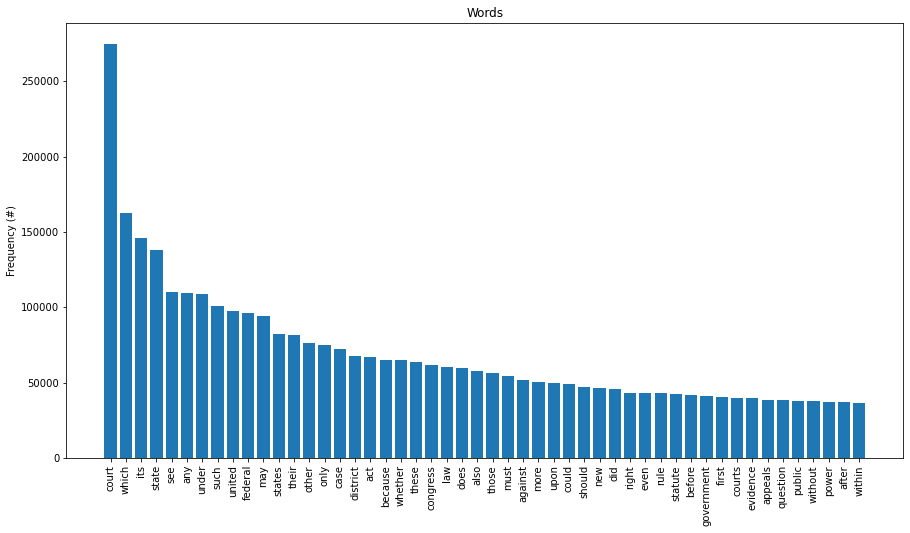

In [23]:
import matplotlib.pyplot as plt

fr = f[:50]
w_w = [k for v,k in fr]
f_w = [v for v,k in fr]
plt.figure(figsize=(15, 8))
plt.bar(w_w,f_w)
plt.ylabel("Frequency (#)")
plt.title("Words")
plt.xticks(rotation=90)
plt.show()

* Let's differentiate between Republicans and Democrats

In [24]:
l = range(len(political_aff))

## DEMOCRATS

authors_D = [authors[i] for i in l if political_aff[i] == 'Democratic']
category_D = [category[i] for i in l if political_aff[i] == 'Democratic']
case_name_D = [case_name[i] for i in l if political_aff[i] == 'Democratic']
year_D = [year[i] for i in l if political_aff[i] == 'Democratic']
political_aff_D = [political_aff[i] for i in l if political_aff[i] == 'Democratic']
case_txt_D = [case_txt[i] for i in l if political_aff[i] == 'Democratic']
case_id_D = [case_id[i] for i in l if political_aff[i] == 'Democratic']
words_txt_D = [words_txt[i] for i in l if political_aff[i] == 'Democratic']

words_D = [word for sentence in words_txt_D for word in sentence]
freq_D = Counter(words_D)
f_D = sorted([(freq_D[k],k) for k in freq_D], reverse = True)
w_w_D = [k for v,k in f_D]
f_w_D = [v for v,k in f_D]

## REPUBLICANS

authors_R = [authors[i] for i in l if political_aff[i] == 'Republican']
category_R = [category[i] for i in l if political_aff[i] == 'Republican']
case_name_R = [case_name[i] for i in l if political_aff[i] == 'Republican']
year_R = [year[i] for i in l if political_aff[i] == 'Republican']
political_aff_R = [political_aff[i] for i in l if political_aff[i] == 'Republican']
case_txt_R = [case_txt[i] for i in l if political_aff[i] == 'Republican']
case_id_R = [case_id[i] for i in l if political_aff[i] == 'Republican']
words_txt_R = [words_txt[i] for i in l if political_aff[i] == 'Republican']

words_R = [word for sentence in words_txt_R for word in sentence]
freq_R = Counter(words_R)
f_R = sorted([(freq_R[k],k) for k in freq_R], reverse = True)
w_w_R = [k for v,k in f_R]
f_w_R = [v for v,k in f_R]

* Frequency of words for each Democratic and Republican party

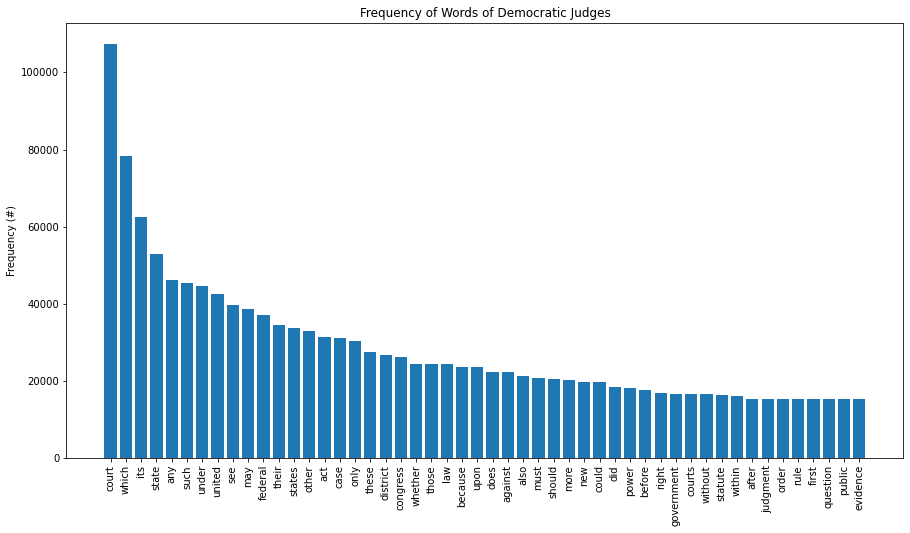

In [25]:
plt.figure(figsize=(15, 8))
plt.bar(w_w_D[:50],f_w_D[:50])
plt.title("Frequency of Words of Democratic Judges")
plt.ylabel("Frequency (#)")
plt.xticks(rotation=90)
plt.show()

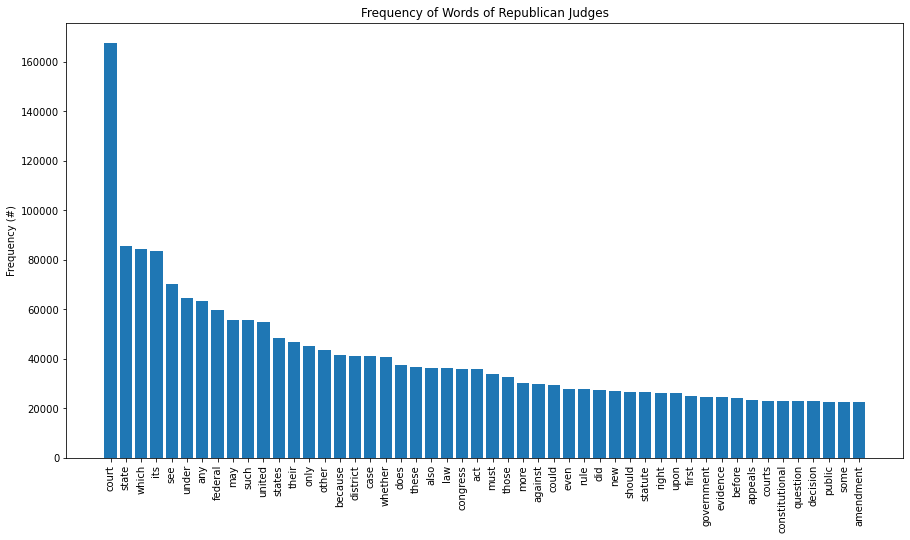

In [26]:
plt.figure(figsize=(15, 8))
plt.bar(w_w_R[:50],f_w_R[:50])
plt.title("Frequency of Words of Republican Judges")
plt.ylabel("Frequency (#)")
plt.xticks(rotation=90)
plt.show()

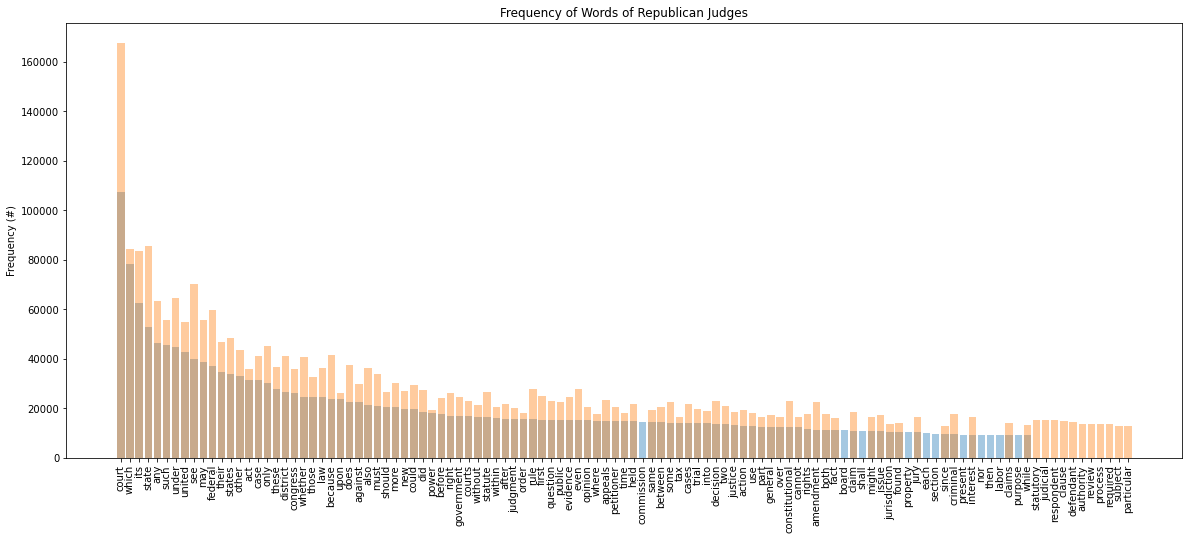

In [27]:
plt.figure(figsize=(20, 8))
plt.bar(w_w_D[:100],f_w_D[:100], alpha=0.4)
plt.bar(w_w_R[:100],f_w_R[:100], alpha=0.4)
plt.title("Frequency of Words of Republican Judges")
plt.ylabel("Frequency (#)")
plt.xticks(rotation=90)
plt.show()

## PMI

In [28]:
import math

only_words_txt = [list(set(only_words)) for only_words in words_txt] #unique words per sentence

words_one_per_sentence = [word for sentence in only_words_txt for word in sentence]
count_words = Counter(words_one_per_sentence)
total_words = len(words_one_per_sentence)

no_sentences = len(only_words_txt)

count_words = Counter(words_one_per_sentence)

count_democratic_words = Counter()
count_Republican_words = Counter()

#Probability word and Democratic
for s in range(len(only_words_txt)):
    if political_aff[s] == 'Democratic':
        for word in only_words_txt[s]:
            count_democratic_words[word] += 1
    if political_aff[s] == 'Republican':
        for word in only_words_txt[s]:
            count_Republican_words[word] += 1

prob_words = {word : (count_words[word]/no_sentences) for word in count_words}
            
prob_democratic_words = {word : (count_democratic_words[word]/no_sentences) for word in count_democratic_words}
prob_Republican_words = {word : (count_Republican_words[word]/no_sentences) for word in count_Republican_words}

prob_democratic_sentences = sum([1 for i in political_aff if i == 'Democratic'])/no_sentences
prob_republican_sentences = sum([1 for i in political_aff if i == 'Republican'])/no_sentences



In [29]:
#PMI for every word and Democrats
PMI_Words_and_Democrats = sorted([(math.log(prob_democratic_words[word]/(prob_words[word]*prob_democratic_sentences)), word) 
                                  for word in prob_words 
                                  if word in prob_democratic_words and count_democratic_words[word] > 10], reverse = True)

#PMI for every word and Republicans
PMI_Words_and_Republicans = sorted([(math.log(prob_Republican_words[word]/(prob_words[word]*prob_republican_sentences)), word) 
                                    for word in prob_words 
                                    if word in prob_Republican_words and count_Republican_words[word] > 10], reverse = True)


print("\nWords with largest PMI's for Democrats:")
for i in range(50):
    print(str(i+1) + '.', PMI_Words_and_Democrats[i][1] + ':', PMI_Words_and_Democrats[i][0])
    
print("\nWords with largest PMI's for Republicans:")
for i in range(50):
    print(str(i+1) + '.', PMI_Words_and_Republicans[i][1] + ':', PMI_Words_and_Republicans[i][0])


Words with largest PMI's for Democrats:
1. honeyman: 0.8347132151581313
2. harrow: 0.8347132151581313
3. embracive: 0.8347132151581313
4. derstand: 0.8347132151581313
5. carloads: 0.8347132151581313
6. perchance: 0.777554801318183
7. permeating: 0.7701746940205603
8. overhanging: 0.7701746940205603
9. escalator: 0.7701746940205603
10. tomkins: 0.76572034367118
11. senn: 0.76572034367118
12. recurringly: 0.76572034367118
13. ecker: 0.76572034367118
14. broderick: 0.76572034367118
15. pathmarking: 0.7640956479441783
16. minton: 0.7623925535785053
17. treinies: 0.7606052430044096
18. raft: 0.7606052430044096
19. prophetic: 0.7606052430044096
20. vitamin: 0.7546705074845951
21. sterilize: 0.7546705074845951
22. revest: 0.7546705074845951
23. choses: 0.7546705074845951
24. assail: 0.7513316062190804
25. streetcar: 0.7477018381685017
26. saturation: 0.7477018381685017
27. kaw: 0.7477018381685017
28. fauntleroy: 0.7477018381685017
29. angle: 0.7346297566011489
30. tin: 0.7234875800479071
31.

Latent Dirichlet Allocation

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=5, suppress=True)

len (df_40)
#type(df_40)

14924

In [31]:
vocab_size = 1000
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words

# document frequency (df) means number of documents a word appears in
tf_vectorizer = CountVectorizer(max_df = 0.5, #discuss max_df, min_df 
                                min_df = 1,
                                stop_words ='english',
                                max_features = vocab_size)
tf = tf_vectorizer.fit_transform(df_40["text"]) #read text column only 


tf.shape

(14924, 1000)

In [32]:
type(tf)

scipy.sparse.csr.csr_matrix

In [33]:
type(tf.toarray())

numpy.ndarray

In [34]:
tf.toarray().shape

(14924, 1000)

In [ ]:
# print(tf_vectorizer.get_feature_names())

In [35]:
tf[0].toarray()

array([[ 35,  12,   7,   3,   7,   6,   4,   7,   3,   4,   0,   0,   1,
          3,   0,   0,   1,   2,   5,   2,   0,   0,   0,   3,   1,   0,
          0,   1,   2,   0,   0,   3,   5,   5,   3,   4,  22,  11,   8,
          6,   8,   8,   2,   2,   2,   2,   1,   3,   0,   1,   1,   8,
          1,   8,  20,   6,   1,   2,   1,   1,   4,   6,   2,   1,   3,
          0,   3,   3,   3,   0,   3,   2,   7,   5,   4,   5,   2,   0,
          0,   2,   0,   0,   0,   0,   1,   1,   0,   2,   0,   1,   2,
          0,   0,   0,   1,   0,   0,   4,   1,  37,   2,   0,   4,   4,
          1,   0,   0,   0,   0,   1,   1,   0,   3,   5,   0,   0,   8,
          1,   1,   0,   5,   1,   2,   0,   1,   0,   0,   1,   0,   2,
          2,   6,   2,   0,   1,   0,   0,   0,   0,   2,   4,   0,   0,
          3,   1,   1,   1,   1,   3,   2,   6,   0,   0,   0,   0,   0,
          5,   3,   3,   1,   1,   0,   1,   0,   9,   0,   1,   0,   0,
          8,   1,   4,   4,   6,   0,   0,   0,   0

We now fit an LDA model to the data

In [36]:
num_topics = 10 #discuss num_topics- how to pick this number 

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

LatentDirichletAllocation(random_state=0)

In [37]:
lda.components_.shape

(10, 1000)

In [38]:
lda.components_.sum(axis=1)

array([1065810.10973,  717972.07193, 1236537.70554,  401094.28337,
       1089181.47777, 1223631.15371,  845530.30748,  997938.71891,
        813510.39052,  849528.78104])

In [39]:
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

In [40]:
topic_word_distributions.shape

(10, 1000)

In [41]:
topic_word_distributions.sum(axis=1) #We can verify that each topic's word distribution sums to 1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [30]:
print(topic_word_distributions[0]) #probabilities for the different words are for a specific topic

[0.00035 0.00055 0.00369 0.00358 0.00324 0.00312 0.00306 0.00264 0.0041
 0.00176 0.00022 0.00044 0.00015 0.00029 0.00021 0.00036 0.00025 0.0003
 0.00051 0.00037 0.00043 0.00056 0.0006  0.00042 0.00048 0.00103 0.00099
 0.00062 0.00092 0.00111 0.00082 0.00222 0.00217 0.0016  0.0013  0.00121
 0.00131 0.00113 0.00118 0.00077 0.00079 0.00125 0.00083 0.00067 0.00079
 0.00119 0.00869 0.00071 0.00063 0.00052 0.00049 0.00048 0.0003  0.00863
 0.01108 0.00079 0.00114 0.00069 0.00061 0.00037 0.0003  0.00048 0.00086
 0.00067 0.00086 0.00007 0.00067 0.00014 0.00104 0.00054 0.00133 0.00092
 0.00266 0.00064 0.00082 0.00148 0.00013 0.00009 0.00015 0.00086 0.00005
 0.00029 0.00151 0.00009 0.00027 0.00065 0.00151 0.00177 0.00042 0.00015
 0.00001 0.0001  0.00014 0.00026 0.0003  0.0008  0.00041 0.00084 0.00008
 0.01171 0.00026 0.00144 0.00285 0.00217 0.00081 0.01438 0.      0.0032
 0.00041 0.00003 0.00045 0.00066 0.      0.      0.00002 0.      0.00043
 0.00163 0.00151 0.00192 0.00297 0.00131 0.00344 0.000

In [42]:
num_top_words = 10 #double check 

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
ante : 0.014383966998849597
amendment : 0.011705243235609446
dissenting : 0.011235126472551845
cite : 0.011227570772179252
____ : 0.011081655490585958
police : 0.010528257551879586
search : 0.01027262577029664
majority : 0.008941156076702886
3d : 0.008691359656120662
___ : 0.008626378348199572

[Topic 1]
tax : 0.048369229964313476
property : 0.03444981830460744
income : 0.01764282754913895
value : 0.011606954139643976
bank : 0.01137615230067932
taxes : 0.010647029808492288
bankruptcy : 0.00989376766860261
trust : 0.008604793750893533
corporation : 0.008065578640044936
business : 0.00801179014481303

[Topic 2]
agency : 0.010815591456485071
secretary : 0.008484260527266002
ed : 0.008016963078150958
ct : 0.00800496232717296
statutory : 0.007903421194679038
respondents : 0.007540065999810629
claims : 0.007528383769055865
regulations : 0.007382058804399118
benefits : 0.007163260284109291
provision :

In [43]:
doc_topic_matrix = lda.transform(tf)

In [44]:
doc_topic_matrix.shape

(14924, 10)

In [45]:
doc_topic_matrix[0]

array([0.24643, 0.04406, 0.0084 , 0.0269 , 0.00004, 0.39379, 0.00004,
       0.00004, 0.27301, 0.00729])

In [ ]:
# pip install https://github.com/sulunemre/word_cloud/releases/download/2/wordcloud-0.post1+gd8241b5-cp39-cp39-win_amd64.whl

(14924, 10)

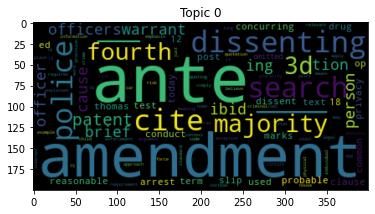

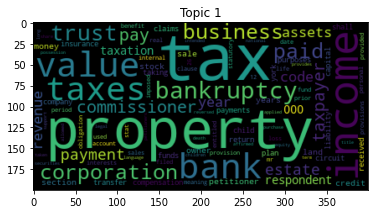

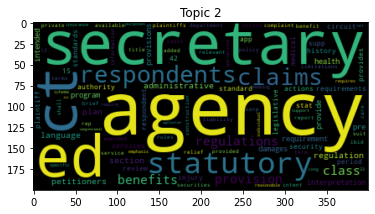

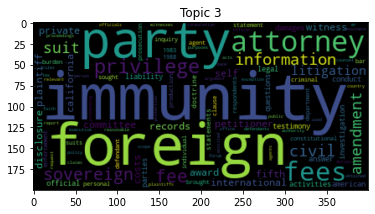

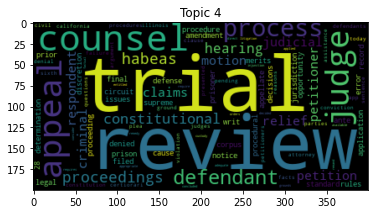

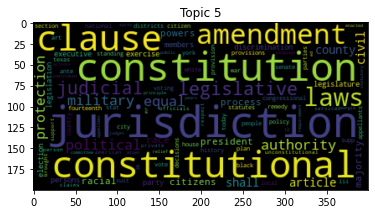

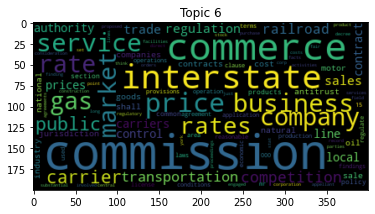

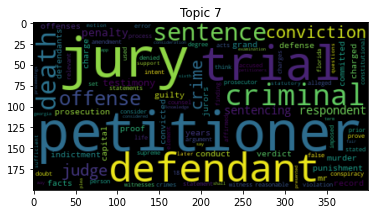

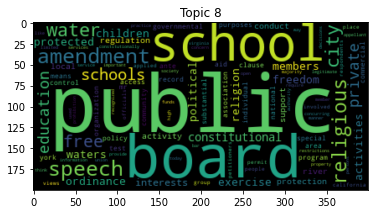

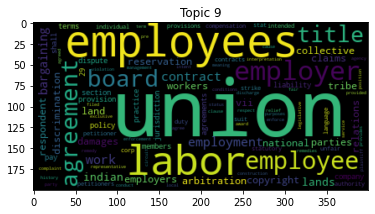

In [46]:
from wordcloud import WordCloud

num_max_word_cloud_words = 100

vocab = tf_vectorizer.get_feature_names()
num_topics = len(topic_word_distributions)

for topic_idx in range(num_topics):
    wc = WordCloud(max_words=num_max_word_cloud_words)
    wc.generate_from_frequencies(dict(zip(vocab, topic_word_distributions[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Topic %d' % topic_idx)

#### Topic 9 - employer and labour
#### Topic 8 - school board, education
#### Topic 7 - death penalty and crime
#### Topic 1 - tax and corporation¶

In [48]:
lsa_300_df = pd.concat(
    [
        df_40[['author_name','year_filed','case_name', 'category']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lsa_300_df.head()

,author_name,year_filed,case_name,category,0,1,2,3,4,5,6,7,8,9
0,Justice Roberts,2014,McCutcheon v. Federal Election Comm'n,majority,0.246430,0.044056,0.008397,0.026899,0.000042,0.393792,0.000042,0.000042,0.273007,0.007294
1,Justice Thomas,2014,McCutcheon v. Federal Election Comm'n,concurring,0.503535,0.000338,0.000338,0.000338,0.000338,0.141915,0.000338,0.000338,0.352185,0.000338
2,Justice Breyer,2014,McCutcheon v. Federal Election Comm'n,dissenting,0.350793,0.047836,0.000052,0.054588,0.000052,0.325193,0.000052,0.000052,0.221331,0.000052
3,Justice Kagan,2014,Kaley v. United States,majority,0.290092,0.085303,0.000060,0.007221,0.195989,0.000060,0.000060,0.421094,0.000060,0.000060
4,Justice Roberts,2014,Kaley v. United States,dissenting,0.185649,0.100577,0.000075,0.004841,0.304687,0.000075,0.000075,0.401613,0.000075,0.002332


In [50]:
lda_df = pd.concat(
    [
        df_40[['author_name','year_filed','case_name', 'category']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lda_by_year = lda_df[['year_filed'] + list(range(num_topics))].groupby('year_filed').agg('mean')
lda_by_year.head()

,0,1,2,3,4,5,6,7,8,9
year_filed,,,,,,,,,,
1940,0.012498,0.341035,0.047092,0.023371,0.119147,0.087011,0.169370,0.046098,0.044922,0.109456
1941,0.010241,0.321825,0.055435,0.029691,0.108093,0.097369,0.167796,0.074785,0.048345,0.086420
1942,0.033238,0.252277,0.044098,0.026535,0.095426,0.087807,0.209554,0.094493,0.048590,0.107982
1943,0.019743,0.235822,0.075515,0.033402,0.094999,0.086694,0.187213,0.112208,0.051989,0.102415
1944,0.021064,0.228475,0.049968,0.028553,0.095790,0.099067,0.221586,0.083836,0.040795,0.130867


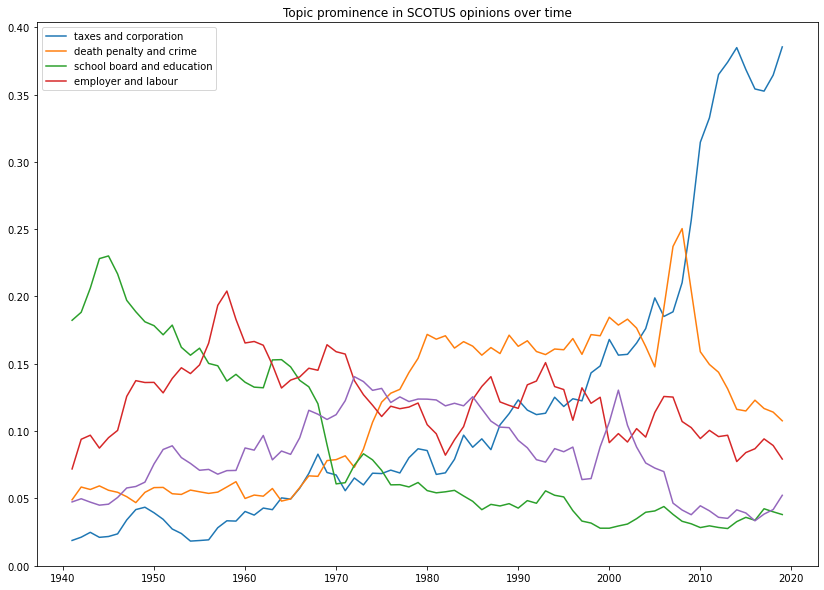

In [51]:
x = lda_by_year.index[1:-1]
plt.figure(figsize=(14,10))

for feature in [1,3,7,8,9]:
    y_vals = list(lda_by_year[feature-1])
    y = [(y_vals[j] + y_vals[j-1] + y_vals[j+1])/3 for j in range(1, len(y_vals)-1)] # rolling mean for smoothing
    plt.plot(x,y)
plt.legend(labels=[
    'taxes and corporation',
    'death penalty and crime',
    'school board and education',
    'employer and labour'
])  
plt.title("Topic prominence in SCOTUS opinions over time")
plt.show()

In [52]:
import seaborn as sns
temporal_sequence = df_40.groupby('author_name').agg('mean').year_filed.sort_values().index
corr_df = lsa_300_df.drop('category', axis=1).groupby('author_name').agg('mean').T.corr()
typicality = corr_df.sum(axis=1)

mask = np.zeros_like(corr_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

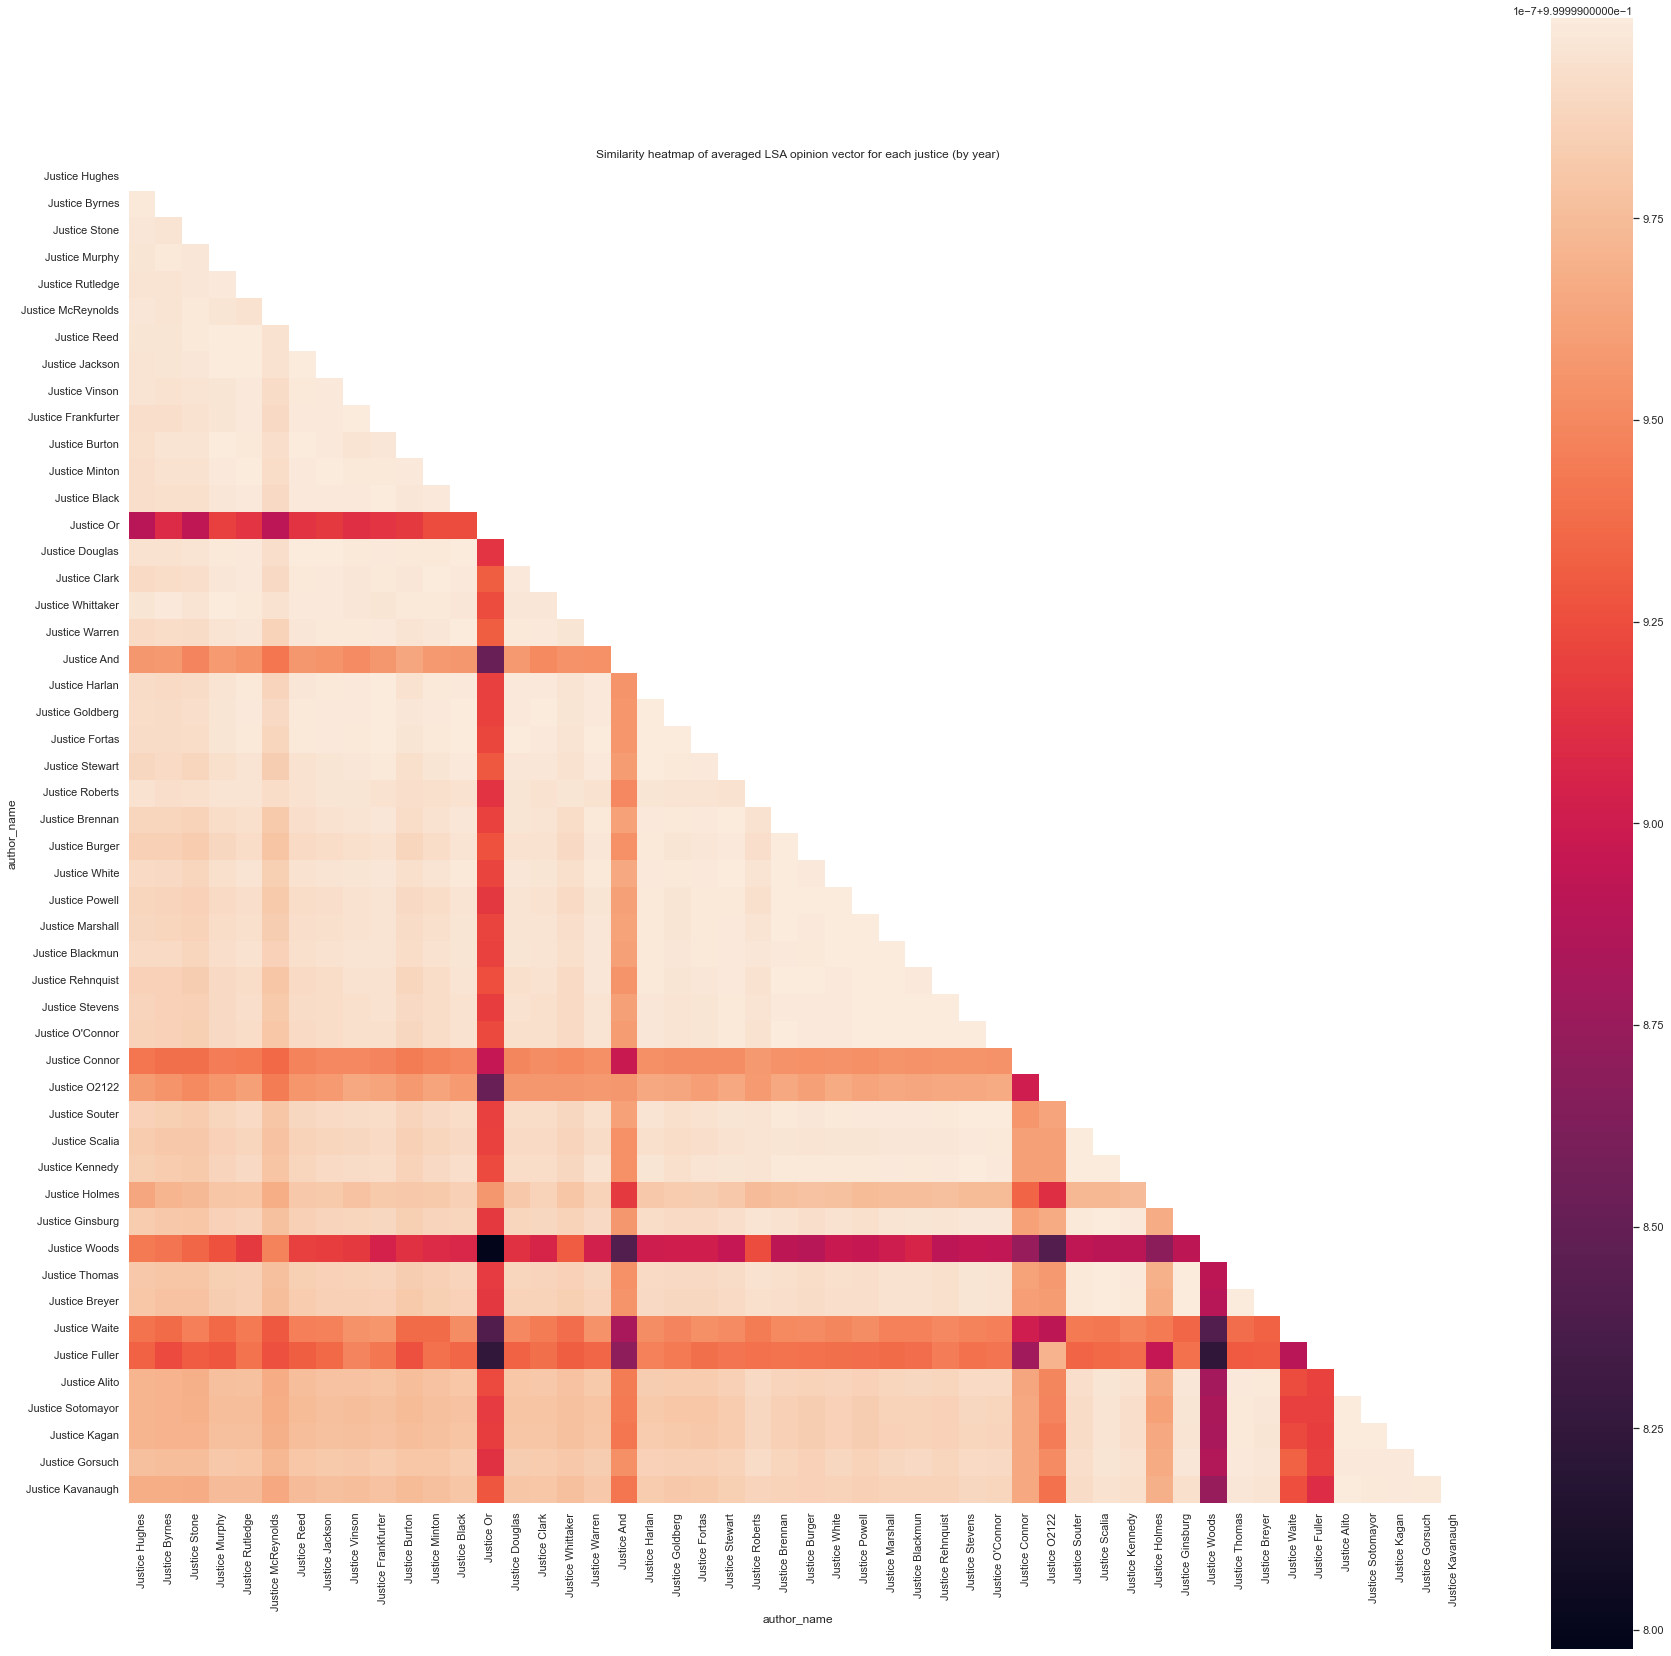

In [53]:
plt.figure(figsize=(30,30))
sns.heatmap(
    lsa_300_df.drop('category', axis=1).groupby('author_name').agg('mean').T.corr().loc[
        temporal_sequence, temporal_sequence
    ],
    square=True,
    mask=mask
)
plt.title("Similarity heatmap of averaged LSA opinion vector for each justice (by year)")
plt.show()

In [55]:
lsa_300_df2 = pd.concat(
    [
        df_40[['author_name','year_filed','case_name', 'category', 'POLITICAL PARTY']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lsa_300_df2.head()

,author_name,year_filed,case_name,category,POLITICAL PARTY,0,1,2,3,4,5,6,7,8,9
0,Justice Roberts,2014,McCutcheon v. Federal Election Comm'n,majority,Republican,0.246430,0.044056,0.008397,0.026899,0.000042,0.393792,0.000042,0.000042,0.273007,0.007294
1,Justice Thomas,2014,McCutcheon v. Federal Election Comm'n,concurring,Republican,0.503535,0.000338,0.000338,0.000338,0.000338,0.141915,0.000338,0.000338,0.352185,0.000338
2,Justice Breyer,2014,McCutcheon v. Federal Election Comm'n,dissenting,Democratic,0.350793,0.047836,0.000052,0.054588,0.000052,0.325193,0.000052,0.000052,0.221331,0.000052
3,Justice Kagan,2014,Kaley v. United States,majority,Democratic,0.290092,0.085303,0.000060,0.007221,0.195989,0.000060,0.000060,0.421094,0.000060,0.000060
4,Justice Roberts,2014,Kaley v. United States,dissenting,Republican,0.185649,0.100577,0.000075,0.004841,0.304687,0.000075,0.000075,0.401613,0.000075,0.002332


In [56]:
lda_by_pp = lsa_300_df2[['POLITICAL PARTY'] + list(range(num_topics))].groupby('POLITICAL PARTY').agg('mean')
lda_by_pp.head()

,0,1,2,3,4,5,6,7,8,9
POLITICAL PARTY,,,,,,,,,,
Democratic,0.085948,0.115313,0.092568,0.043277,0.121125,0.115703,0.126669,0.120267,0.078551,0.100577
Republican,0.125158,0.069637,0.136247,0.047414,0.140842,0.125317,0.058360,0.122773,0.096527,0.077725
